Training of ResNet-110 on CIFAR10 with a high learning rate and a warmup period.

Analysis of layer rotation curves and training curves.

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import warnings
import os
import time

import math as m
import numpy as np
np.random.seed(1)

import matplotlib
import matplotlib.pyplot as plt
import pickle

from experiment_utils import history_todict, get_val_split
from layer_rotation_utils import LayerRotationCurves, plot_layer_rotation_curves
from layca_optimizers import SGD

from import_task import import_task
from get_training_utils import get_training_schedule, get_optimized_training_schedule
from get_training_utils import get_stopping_criteria, get_optimizer, get_learning_rate_multipliers

from lr_scheduler_with_warmup import LearningRateScheduler_with_warmup

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
# utilities for storing the results in pickle files
result_file = 'results_lr_warmup.p'
def load_results():
    if not os.path.isfile(result_file):
        return {}
    else:
        with open(result_file,'rb') as f:
            return pickle.load(f)

def dump_results(results):
    with open(result_file,'wb') as f:
        pickle.dump(dict(results),f)

def update_results(path, new_data):
    results = load_results()
    position = results
    for p in path:
        position = position[p]
    # new_data is a dictionary with the new (key,value) pairs
    position.update(new_data)
    dump_results(results)

In [4]:
# if results should be saved in the file or not
save_results = True
if not save_results:
    results = {}
# file for monitoring the experiment's progress
monitor_file = 'monitor_lr_warmup.txt' 

In [ ]:
tasks = ['C10-resnet']#,'C100-resnet','tiny-CNN','C10-CNN2','C100-WRN']
optimizers = ['SGD_layca']#,'Adam', 'RMSProp', 'Adagrad']
warmups = [0]

for task in tasks:
    x_train, y_train, x_test, y_test, get_model = import_task(task)
    
    # no validation set needed because no meta-parameters are tuned, but forgot to remove it
    [x_train, y_train], [x_val, y_val] = get_val_split(x_train,y_train, 0.1)
    
    # creates empty dictionary if first time the task is seen
    if save_results:
        results = load_results()
        if task not in results.keys():
            update_results([],{task:{}})
    elif task not in results.keys():
        results.update({task:{}})
    
    for optimizer in optimizers:        
        if save_results:
            results = load_results()
            if optimizer not in results[task].keys():
                update_results([task],{optimizer:{}})
        elif optimizer not in results[task].keys():
            results[task].update({optimizer:{}})
        
        for warmup in warmups:
            start = time.time()
            model = get_model(weight_decay = 0.) if 'weight_decay' not in optimizer else get_model()

            batch_size = 128
            epochs, lr, lr_scheduler = get_optimized_training_schedule(task,optimizer)                
            lr_scheduler = LearningRateScheduler_with_warmup(lr_scheduler.schedule, 
                                                             warmup_type = 'continuous',warmup_period = warmup,
                                                             steps_per_epoch = np.floor(x_train.shape[0]//batch_size))
        
            stop_callback = get_stopping_criteria(task)
            verbose = 1

            # frequency at which cosine distance from initialization is computed
            batch_frequency = int((x_train.shape[0]/batch_size))+5 # higher value than # of batches per epoch means once per epoch
            ladc = LayerRotationCurves(batch_frequency = batch_frequency)

            callbacks = [lr_scheduler, ladc]+ stop_callback

            multipliers = get_learning_rate_multipliers(model,alpha = 0.)
            # C100-WRN + SGD is the only case where nesterov momentum is used (cfr. original implementation)
            if task in ['C100-WRN'] and optimizer in ['SGD','SGD_weight_decay']: 
                opt = SGD(lr=lr, momentum=0.9, nesterov=True,multipliers = multipliers)
            else:
                opt = get_optimizer(optimizer, lr,multipliers)
            metrics = ['accuracy', 'top_k_categorical_accuracy'] if 'tiny' in task else ['accuracy']
            model.compile(loss='categorical_crossentropy',
                          optimizer= opt,
                          metrics=metrics)

            # C100-resnet and tiny-CNN need early stopping
            if task=='C100-resnet' or 'tiny' in task:
                weights_file = 'saved_weights/best_weights_'+str(np.random.randint(1e6))+'.h5'
                callbacks += [ModelCheckpoint(weights_file, monitor='val_acc', save_best_only=True, save_weights_only = True)]


            with warnings.catch_warnings():
                if task in ['C10-CNN2','C100-WRN','C10-resnet']:
                    print('Using data augmentation')
                    # data augmentation
                    datagen = ImageDataGenerator(width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='reflect',
                             horizontal_flip=True)

                    warnings.simplefilter("ignore") # removes warning from keras for slow callback
                    history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                                  epochs = epochs,
                                                  verbose = verbose,
                                                  validation_data = (x_val,y_val),
                                                  callbacks = callbacks)
                else:
                    warnings.simplefilter("ignore") # removes warning from keras for slow callback
                    history = model.fit(x_train,y_train,
                                        epochs = epochs,
                                        batch_size = batch_size,
                                        verbose = verbose,
                                        validation_data = (x_val,y_val),
                                        callbacks = callbacks)

            # application of early stopping
            if task=='C100-resnet' or 'tiny' in task:
                model.load_weights(weights_file)

            test_performance = model.evaluate(x_test,y_test, verbose = verbose)

            if save_results:
                update_results([task, optimizer],{warmup:{'history':history_todict(history),'ladc':ladc.memory,
                                                      'test_performance':test_performance}})
            else:
                results[task][optimizer].update({warmup:{'history':history_todict(history),'ladc':ladc.memory,
                                                     'test_performance':test_performance}})


            with open(monitor_file,'a') as file:
                file.write(task + ', '+optimizer+', '+str(warmup)+': done in '+str(time.time()-start)+' seconds.\n')

In [5]:
results = load_results()

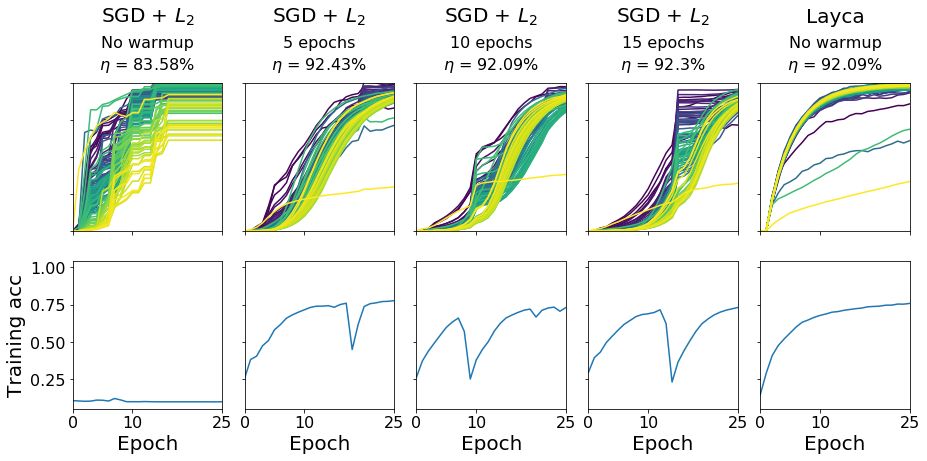

In [12]:
mpld3.disable_notebook()
matplotlib.rcParams.update({'font.size': 16})
warmups = [0, 5, 10, 15,0] # last warmup value corresponds to Layca training

warmup_labels = []
for warmup in warmups:
    warmup_label = str(warmup)+' epochs' if warmup>0 else 'No warmup'
    warmup_labels.append(warmup_label)

optimizer_labels = {'SGD_weight_decay':'SGD + $L_2$', 'SGD_layca': 'Layca'}

f, axes = plt.subplots(2,len(warmups), figsize = (3*len(warmups),6), sharex = 'col', sharey = 'row')
for j,warmup in enumerate(warmups):
    if j < len(warmups)-1:
        optimizer = 'SGD_weight_decay'
    else:
        optimizer = 'SGD_layca'
    
    plot_layer_rotation_curves(results['C10-resnet'][optimizer][warmup]['ladc'], ax = axes[0,j])
    axes[0,j].set_title('$\eta$ = '+str(round((results['C10-resnet'][optimizer][warmup]['test_performance'][1])*100,2))+'%',
                      fontsize=16, y=1.05)
        
    axes[0,j].set_xlabel('')
    axes[0,j].set_ylabel('')
    axes[0,j].set_yticklabels('')
#     if j>0:
#         axes[0,j].set_ylabel('')
#     else:
#         axes[0,j].set_ylabel('Cosine distance',fontsize=20)
#     axes[0,j].set_xlim([0,20])
#     axes[0,j].set_xticks([0,10,20]) 
    
    axes[1,j].plot(results['C10-resnet'][optimizer][warmup]['history']['epoch'], 
                   results['C10-resnet'][optimizer][warmup]['history']['history']['acc'])
    
    if j==0:
        axes[1,j].set_ylabel('Training acc',fontsize=20)
#         axes[1,j].set_yticks([0,0.1,0.2,0.3,0.4])
    axes[1,j].set_xlabel('Epoch',fontsize=20)
    axes[1,j].set_xlim([0,25])
    axes[1,j].set_xticks([0,10,25]) 

    pad = 35
    size = 16
    axes[0,j].annotate(warmup_labels[j], xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=size, ha='center', va='baseline')
    
    pad = 60
    size = 20
    axes[0,j].annotate(optimizer_labels[optimizer], xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=size, ha='center', va='baseline')

plt.subplots_adjust(hspace=0.2,wspace=0.15)
plt.savefig('figures/warmup_analysis.png',format='png', dpi=200, bbox_inches="tight")

In [14]:
warmups = [0, 5, 10, 15,0] # last warmup value corresponds to Layca training
performances = []
for j,warmup in enumerate(warmups):
    if j < len(warmups)-1:
        optimizer = 'SGD_weight_decay'
    else:
        optimizer = 'SGD_layca'
        
    performances.append(round((results['C10-resnet'][optimizer][warmup]['history']['history']['acc'][-1]),4))
print(performances)

[0.9667, 0.9976, 0.9985, 0.9968, 0.9985]
